# XGBoost Auto Insurance Claim Prediction

- Import Data
- Data Cleaning
- Feature Selection
- Data Pre-processing
- Model training
- Data Re-sampling
- Hyperparamater tuning
- Final Model Evaluation


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

##import ML libraries for training, testing and evaluating Xgboost model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score, roc_auc_score, roc_curve
import xgboost as xgb

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC


## 1) Import data

data from - https://www.kaggle.com/datasets/sudhanshu2198/insurance-claim-prediction

44 columns with varying data types. 

Data requires significant cleaning; for example max_power stored as string "40.36bhp@6000rpm"


In [55]:
data = pd.read_csv('data/train.csv')
data.head(10)

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
5,ID00006,1.018709,0.07,0.519231,C6,13051,3,C2,M4,Diesel,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
6,ID00007,0.097992,0.16,0.403846,C7,6112,4,B2,M5,Diesel,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0
7,ID00008,0.509085,0.14,0.423077,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
8,ID00009,0.282394,0.07,0.298077,C7,6112,3,C2,M4,Diesel,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
9,ID00010,0.566255,0.04,0.442308,C9,17804,1,B2,M7,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,0


## 2) Data Cleaning

### Check for missing values

In [56]:

##count na values in each column
na_counts = data.isna().sum()
##sort the counts in descending order
na_counts.sort_values(ascending=False, inplace=True)
##show columns with at least 1 na value
na_counts[na_counts > 0]

Series([], dtype: int64)

In [57]:
##add number of unique values for each column to a dataframe
unique_values = pd.DataFrame(data.nunique(), columns=['unique_values'])
##sort the dataframe in descending order
unique_values.sort_values(by='unique_values', ascending=False, inplace=True)
##show columns with at less than 5 unique values
unique_values[unique_values['unique_values'] < 8]
    

,unique_values
segment,6
ncap_rating,5
make,5
fuel_type,3
steering_type,3
airbags,3
is_brake_assist,2
is_ecw,2
is_power_door_locks,2
is_central_locking,2


## How balanced is the data? What is the distribution of the target variable?

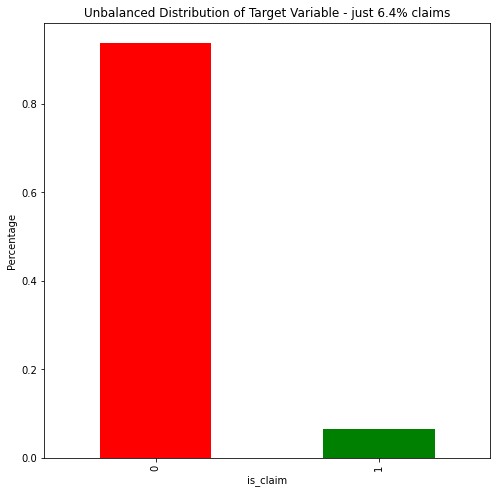

In [58]:
target = data['is_claim']
##plot the distribution of the target variable as percentage with value labels
target_counts = target.value_counts(normalize=True)
perc_claims = target_counts[1]*100

target_counts.plot(kind='bar', 
                   title=f"Unbalanced Distribution of Target Variable - just {perc_claims:.1f}% claims", color=['red', 'green'])
plt.xlabel('is_claim')
plt.ylabel('Percentage')
plt.show()



## Convert types

Binary variables encoded by "Yes"/"No" strings - convert 1/0

In [59]:
##function to change binary categorical variables to 1/0. Input may not be yes/no but any binary categorical variable
def yes_no_to_1_0(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return x
    


##find all columns with yes/no values, 2 unique values and contains the string "Yes"
yes_no_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col].dtype == 'object' and 'Yes' in data[col].unique()]

##apply the function to the dataframe
data[yes_no_cols] = data[yes_no_cols].applymap(yes_no_to_1_0)
##covert yes/no columns to categorical variables
data[yes_no_cols] = data[yes_no_cols].astype('category')

##view the first 10 rows of the dataframe
data[yes_no_cols].head(10)


,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
6,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,1,1
7,0,1,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
9,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


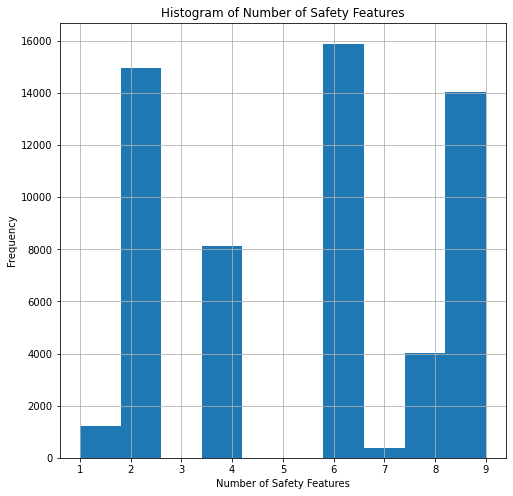

In [60]:
parking_assistance = ['is_parking_sensors','is_parking_camera','is_power_steering']
safety_features = parking_assistance+['is_front_fog_lights','is_central_locking','is_brake_assist','is_power_door_locks','is_tpms','is_esc']
##boolean for rows with at least 3 safety feature
data['at_least_3_safety_feats'] = data[safety_features].sum(axis=1) >= 3
##boolean for over 8 safety feature
data['over_8_safety_feats'] = data[safety_features].sum(axis=1) > 8
##boolean for at least 1 parking assistance feature
data['at_least_1_parking_assist'] = data[parking_assistance].sum(axis=1) >= 1
##sum the number of safety features for each row
data['n_safety_features'] = data[safety_features].sum(axis=1)
##sum the number of parking assistance features for each row
data['n_parking_assist'] = data[parking_assistance].sum(axis=1)


##plot histogram of the number of safety features
data['n_safety_features'].hist(bins=10)
plt.title('Histogram of Number of Safety Features')
plt.xlabel('Number of Safety Features')
plt.ylabel('Frequency')
plt.show()



Max power and max_torque encoded as string - e.g. "40.36bhp@6000rpm". Extract number and convert to numeric

In [61]:
##extract number from max_power column (e.g. 40.36bhp@6000rpm to 40.36)
data['max_power'] = data['max_power'].str.extract('(\d+\.\d+)').astype(float)

##extract number from max_torque column (e.g. 200Nm@1750-2750rpm to 200)
data['max_torque'] = data['max_torque'].str.extract('(\d+)').astype(float)

data.info

<bound method DataFrame.info of       policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0       ID00001       0.515874        0.05             0.644231           C1   
1       ID00002       0.672619        0.02             0.375000           C2   
2       ID00003       0.841110        0.02             0.384615           C3   
3       ID00004       0.900277        0.11             0.432692           C4   
4       ID00005       0.596403        0.11             0.634615           C5   
...         ...            ...         ...                  ...          ...   
58587   ID58588       0.355089        0.13             0.644231           C8   
58588   ID58589       1.199642        0.02             0.519231          C14   
58589   ID58590       1.162273        0.05             0.451923           C5   
58590   ID58591       1.236307        0.14             0.557692           C8   
58591   ID58592       0.124429        0.02             0.442308           C8   

       

## 3) Feature Selection

### Which numeric variables are most associated with `is_claim`

Perform pairwise pearson correlation across all numeric variables. 

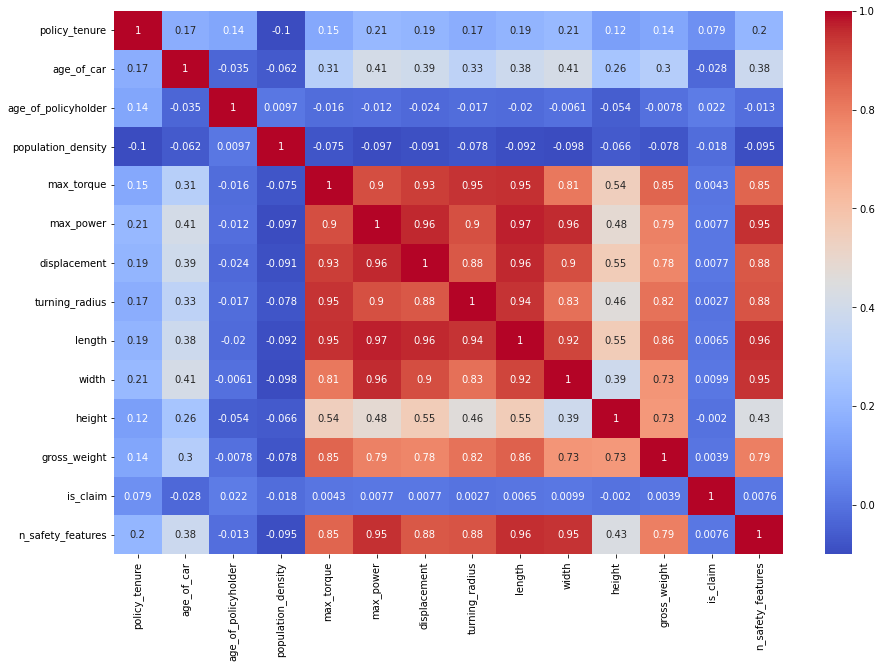

In [62]:
## identify numerical columns
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
## remove from num cols if 8 or less unique values, but keep target variable
num_cols = [col for col in num_cols if data[col].nunique() > 5 or col == 'is_claim']
##plot correlation matrix
corr = data[num_cols].corr(method='pearson')
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()




### Perform Ridge and Lasso regression

Using `LogisticRegression` fit lasso and ridge regression models - better for determining variables associated with `is_claim`, as they deal better with colinearity. 

Model coefficents will be used to determine which varaibles are most associated with `is_claim`. 

In [63]:
##scale the numerical columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[num_cols]), columns=num_cols)

scaled_data['is_claim'] = target

num_cols_not_target = [col for col in num_cols if col != 'is_claim']

In [64]:
from sklearn.linear_model import LogisticRegression
ridge_reg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs')
ridge_reg.fit(scaled_data[num_cols_not_target], target)


lasso_reg = LogisticRegression(penalty='l1', C=1.0, solver='saga')
lasso_reg.fit(scaled_data[num_cols_not_target], target)

##add both sets of coefficients to a dataframe
coef_df = pd.DataFrame({ 'ridge_coef': ridge_reg.coef_[0], 'lasso_coef': lasso_reg.coef_[0]}, index=num_cols_not_target)
##arrange by absolute ridge + lasso coefficient value
coef_df = coef_df.reindex(coef_df.abs().sum(axis=1).sort_values(ascending=False).index)
coef_df

,ridge_coef,lasso_coef
policy_tenure,0.347926,0.347790
age_of_car,-0.203656,-0.203077
displacement,0.168054,0.156365
max_power,-0.147459,-0.117189
turning_radius,-0.125481,-0.123349
length,0.117601,0.080385
gross_weight,0.093636,0.090910
height,-0.083256,-0.079187
max_torque,-0.062060,-0.046233
population_density,-0.051564,-0.051233


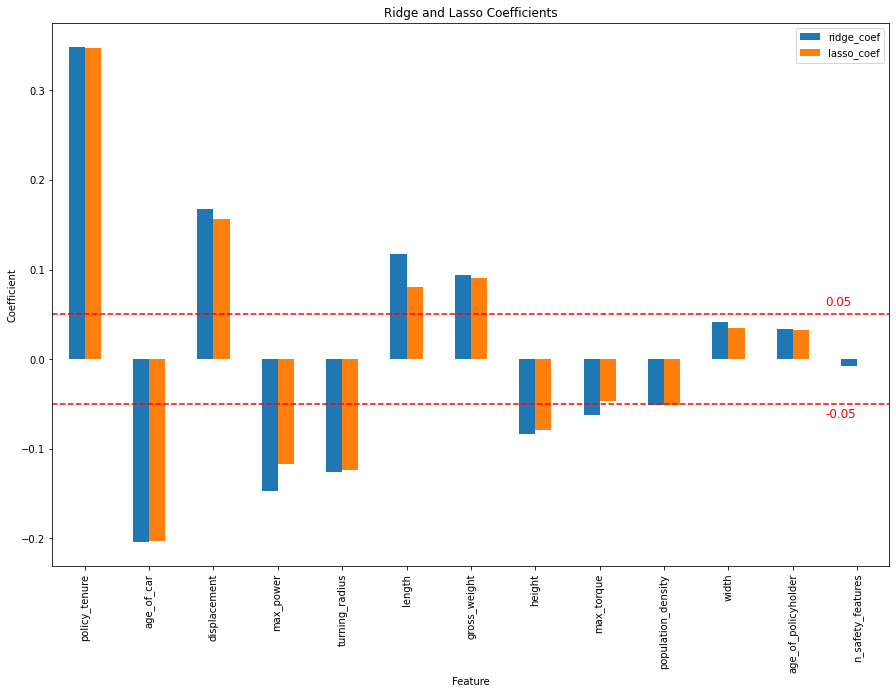

In [65]:
##plot the coefficients
coef_df.plot(kind='bar', figsize=(15,10))
plt.title('Ridge and Lasso Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
##add horizontal line at +-0.05 for cutoff
plt.axhline(y=0.05, color='r', linestyle='--')
plt.axhline(y=-0.05, color='r', linestyle='--')
##label lines on the right of plot as coefficent cutoff
plt.text(x=coef_df.shape[0]-1.5, y=0.06, s='0.05', color='r', fontsize=12)
plt.text(x=coef_df.shape[0]-1.5, y=-0.065, s='-0.05', color='r', fontsize=12)

plt.show()

### Plot Binomial Regression 

Define a function that uses `statsmodels.api.GLM` to fit a binomial Generalized linear model (GLM) model and plot the results. 

The plot will show the GLM-predicted probability of a claim occuring at each x-value of the specified feature

In [133]:
##add option to set ylim
def plot_binomial_regression(x, y=data['is_claim'], title='', xlabel='', ylabel='Claim Probability', ylim=None, figsize=(10, 4.5)):
    """Plot a binomial regression line on a scatter plot of the data.

    Parameters
    ----------
    x : array-like
        The predictor variable. Must be a 1-dimensional array.  
    y : array-like, optional
        The response variable. Must be a 1-dimensional array. Defaults to `data['is_claim']`.
    title : str, optional
        The title of the plot. Defaults to ''.
    xlabel : str, optional
        The label of the x-axis. Defaults to ''.
    ylabel : str, optional
        The label of the y-axis. Defaults to 'Claim Probability'.
    ylim : tuple, optional
        The limits of the y-axis. Defaults to None.
    figsize : tuple, optional
        The size of the plot. Defaults to (10, 4.5).

    Returns
    -------
    None
    """

    # Fit the binomial GLM model
    binomial_reg = sm.GLM(y, sm.add_constant(x), family=sm.families.Binomial()).fit()

    # Generate predicted values for plotting the line
    x_pred = np.linspace(x.min(), x.max(), 100)
    y_pred = binomial_reg.predict(sm.add_constant(x_pred))

    # Plot the data points and the regression line
    fig, ax = plt.subplots(figsize=figsize)
    #ax.scatter(x, y, color='b', alpha=0.5, label='Data')
    ax.plot(x_pred, y_pred, color='r', label='Regression Line')
    ax.axhline(target_counts[1], color='k', linestyle='--', label='Overall Claim Rate')

    ##set ylim if specified
    if ylim:
        ax.set_ylim(ylim)
    
    # Add plot labels and legend
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

    plt.show()


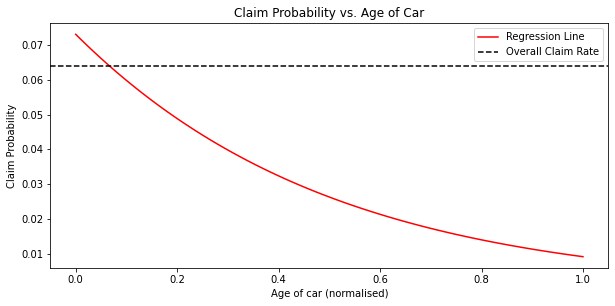

In [128]:
plot_binomial_regression(x=data['age_of_car'], title='Claim Probability vs. Age of Car',xlabel='Age of car (normalised)')


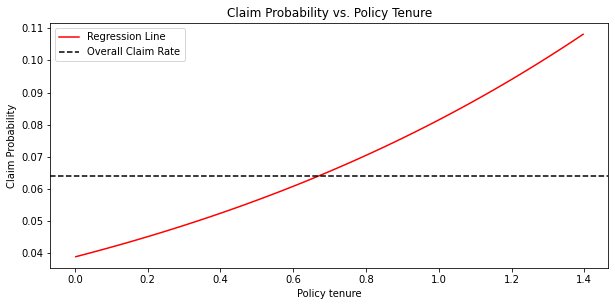

In [129]:
plot_binomial_regression(data['policy_tenure'], title='Claim Probability vs. Policy Tenure',xlabel='Policy tenure')

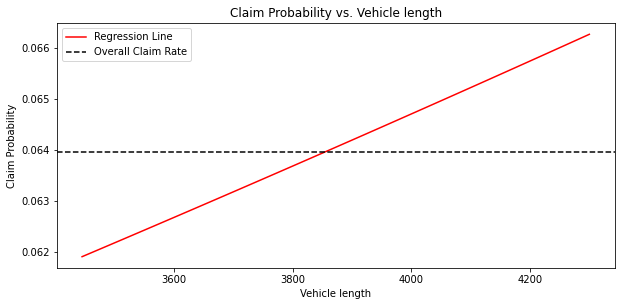

In [130]:
plot_binomial_regression(data['length'], title='Claim Probability vs. Vehicle length',xlabel='Vehicle length')

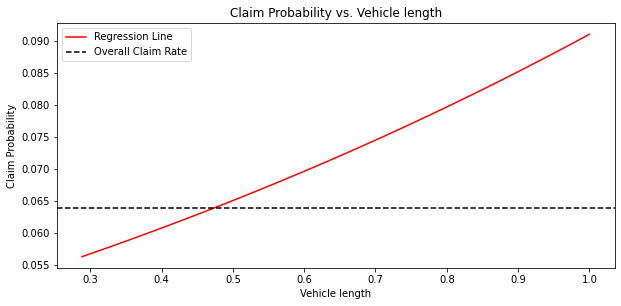

In [131]:
plot_binomial_regression(data['age_of_policyholder'], title='Claim Probability vs. Age of Policy holder',xlabel='Age of Policy holder (normalised)')

### Perform a chi-squared test (feature selection for categorical varaibles)

Here we're performing a statistical test to determine which categorical variable differ from the expected values. 

I.e. if 20% of all vehicles insured have parking sensors, is percentage of vehicles that claimed statistically different from 20%

In [71]:
##perform a chi-squared test to see if there is a relationship between the target variable and the yes_no_cols
from scipy.stats import chi2_contingency

## identify all categorical variables in the dataset (not in num_cols, and not target variable)
cat_cols = [col for col in data.columns if col not in num_cols and col != 'is_claim']


##create a dataframe to store results
chi2_results = pd.DataFrame(columns=['chi2', 'p_value', 'n degrees of freedom'])

##loop through each column cat_cols and yes_no_cols and perform chi-squared test
for col in cat_cols:
    ##create a contingency table
    contingency_table = pd.crosstab(data[col], data['is_claim'])
    ##perform a chi-squared test
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    

    #add results to dataframe
    chi2_results.loc[col] = [chi2, p, dof]



### Plot chi-squared results

We adjust the p-values for multiple testing correction (using bonferroni-hochberg)

And visualise p-values as their -log10(adjusted p-value). Hence p=1*10^-4 becomes 4

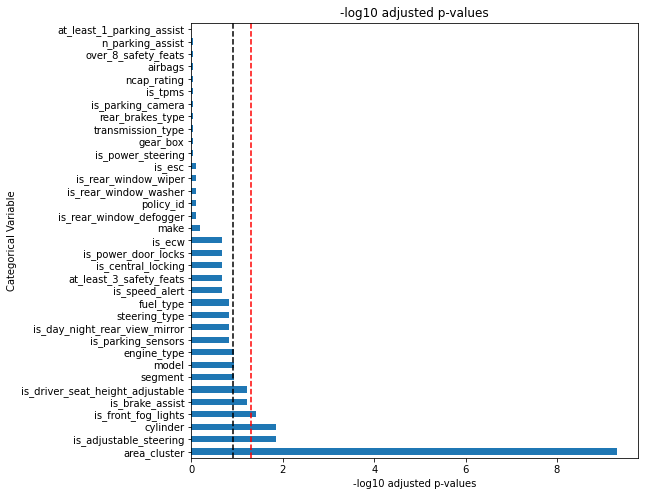

In [72]:

##adjust the p-values for multiple testing
chi2_results['p_adj'] = multipletests(chi2_results['p_value'], method='fdr_bh')[1]
##add minus log10 adjusted p-value
chi2_results['minus_log10_p_adj'] = -np.log10(chi2_results['p_adj'])
##sort the values in descending order
chi2_results.sort_values(by='minus_log10_p_adj', ascending=False, inplace=True)


#incrwease the size of the plot
plt.rcParams['figure.figsize'] = [8, 8]
##plot the -log10 adj p-values  
chi2_results['minus_log10_p_adj'].plot(kind='barh', title='-log10 adjusted p-values')
plt.ylabel('Categorical Variable')
plt.xlabel('-log10 adjusted p-values')
##add vertical line at -log10 0.05
plt.axvline(x=-np.log10(0.125), color='black', linestyle='--')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--')
plt.show()

## 4) Data Pre-processing for ML

### Drop columns which are have low association with `is_claim`

- Catgeorical varaibles with Chi-squared adj-p-value >0.2 (hence 1 out 5 chance their distribution is random)
- Numerical variables with both lasso and ridge absolute coefficent over 0.05

In [73]:
##drop chi2_results with p_adj > 0.25
cols_to_drop = chi2_results[chi2_results['p_adj'] > 0.2].index.tolist()
##drop min lasso and ridge regression absolute coefficient values < 0.05
cols_to_drop += coef_df[coef_df.abs().min(axis=1) < 0.05].index.tolist()

data2 = data.drop(columns=cols_to_drop)
data2.head()


,policy_tenure,age_of_car,area_cluster,population_density,segment,model,fuel_type,max_power,engine_type,is_adjustable_steering,...,steering_type,turning_radius,length,height,gross_weight,is_front_fog_lights,is_brake_assist,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_claim
0,0.515874,0.05,C1,4990,A,M1,CNG,40.36,F8D Petrol Engine,0,...,Power,4.6,3445,1475,1185,0,0,0,0,0
1,0.672619,0.02,C2,27003,A,M1,CNG,40.36,F8D Petrol Engine,0,...,Power,4.6,3445,1475,1185,0,0,0,0,0
2,0.841110,0.02,C3,4076,A,M1,CNG,40.36,F8D Petrol Engine,0,...,Power,4.6,3445,1475,1185,0,0,0,0,0
3,0.900277,0.11,C4,21622,C1,M2,Petrol,88.50,1.2 L K12N Dualjet,1,...,Electric,4.8,3995,1515,1335,1,1,1,1,0
4,0.596403,0.11,C5,34738,A,M3,Petrol,67.06,1.0 SCe,0,...,Electric,5.0,3731,1490,1155,0,0,0,1,0


### Add a number of entirely random variables (for more feature selection)

It can be assumed that the random varaibles have zero-importance to our feature, hence any feature in our trained model that have lower importance than the random variables should be removed.

In [74]:
##get a random choice from numpy array
def get_random_choice(arr):
    """
    Get a random choice from a numpy array.

    Args:
        arr (numpy array): The array to sample from.

    Returns:
        (numpy array): The random sample.
    """
    return arr[np.random.choice(arr.shape[0], 1)[0]]

p_vals = np.array([0.02,0.1,0.25,0.5,0.75])


In [75]:
## add 10 random normally distributed column to the data in order to assess feature importance
for i in range(15):
    ##create a random normally distributed column
    data2[f'random_normal_{i}'] = np.random.normal(size=data2.shape[0])
    data2[f'random_binomial_{i}'] = np.random.binomial(n=1, p=get_random_choice(p_vals), size=data2.shape[0])



### Create dummy varaibles for categorical columns and random_binomial columns

In [76]:
##remove dropped columns from cat_cols
cat_cols = [col for col in cat_cols if col not in cols_to_drop]
##add random_binomial columns to cat_cols
cat_cols += [col for col in data2.columns if 'random_binomial' in col]


##create dummy variables
data2 = pd.get_dummies(data2, columns=cat_cols, drop_first=True)
data2.head()



,policy_tenure,age_of_car,population_density,max_power,displacement,turning_radius,length,height,gross_weight,is_claim,...,random_binomial_5_1,random_binomial_6_1,random_binomial_7_1,random_binomial_8_1,random_binomial_9_1,random_binomial_10_1,random_binomial_11_1,random_binomial_12_1,random_binomial_13_1,random_binomial_14_1
0,0.515874,0.05,4990,40.36,796,4.6,3445,1475,1185,0,...,0,1,1,1,0,0,0,1,0,0
1,0.672619,0.02,27003,40.36,796,4.6,3445,1475,1185,0,...,0,0,1,0,0,1,0,0,0,1
2,0.841110,0.02,4076,40.36,796,4.6,3445,1475,1185,0,...,0,0,0,0,0,0,0,0,1,1
3,0.900277,0.11,21622,88.50,1197,4.8,3995,1515,1335,0,...,0,0,1,0,0,0,0,1,1,1
4,0.596403,0.11,34738,67.06,999,5.0,3731,1490,1155,0,...,0,0,1,0,0,0,0,1,1,0


### Scale numerical columns and random_normal columns

In [77]:
##create a list of columns to scale random_normal columns and num_cols 
scale_cols = [col for col in data2.columns if 'random_normal' in col or col in num_cols]
##do not scale target variable ('is_claim')
scale_cols.remove('is_claim')

##create a scaler object
scaler = StandardScaler()
##fit the scaler to the data
scaler.fit(data2[scale_cols])
##transform the data
data2[scale_cols] = scaler.transform(data2[scale_cols])

data2.head()

,policy_tenure,age_of_car,population_density,max_power,displacement,turning_radius,length,height,gross_weight,is_claim,...,random_binomial_5_1,random_binomial_6_1,random_binomial_7_1,random_binomial_8_1,random_binomial_9_1,random_binomial_10_1,random_binomial_11_1,random_binomial_12_1,random_binomial_13_1,random_binomial_14_1
0,-0.230283,-0.342447,-0.783513,-1.394156,-1.375713,-1.108893,-1.301882,-0.983846,-0.942828,0,...,0,1,1,1,0,0,0,1,0,0
1,0.148188,-0.871359,0.462975,-1.394156,-1.375713,-1.108893,-1.301882,-0.983846,-0.942828,0,...,0,0,1,0,0,1,0,0,0,1
2,0.555022,-0.871359,-0.835268,-1.394156,-1.375713,-1.108893,-1.301882,-0.983846,-0.942828,0,...,0,0,0,0,0,0,0,0,1,1
3,0.697883,0.715378,0.158275,0.343811,0.130093,-0.231926,0.464026,-0.481470,-0.236684,0,...,0,0,1,0,0,0,0,1,1,1
4,-0.035840,0.715378,0.900969,-0.430223,-0.613422,0.645040,-0.383610,-0.795455,-1.084057,0,...,0,0,1,0,0,0,0,1,1,0


### Make train-test split 

Using `stratify=y` so that test and train sets have equal proportions of y==True

In [78]:
##create x and y variables
X = data2.drop(columns='is_claim')
y = data2['is_claim']

##split the data into train and test sets
##all suffix to show these are not feature selected
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##count the value and percentage of 1s and 0s in the train and test sets
for df in [y_train, y_test]:
    print(df.value_counts())

0    43875
1     2998
Name: is_claim, dtype: int64
0    10969
1      750
Name: is_claim, dtype: int64


In [79]:
##calculate ratio of 1s to 0s in the train set
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
ratio

14.634756504336224

## 5) Model Training

In [80]:
##fit the model to the training data
##create an xgb classifier object with 750 trees
##unbalanced dataset so use scale_pos_weight to balance the classes


xgb_clf = xgb.XGBClassifier(n_estimators=500, 
                            scale_pos_weight=ratio*3, 
                            random_state=42, 
                            n_jobs=-1,
                            objective='binary:logistic', 
                            eval_metric='logloss')


xgb_clf.fit(X_train_all, y_train)

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=43.90426951300867,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Function to evaluate model performance using metrics such as precision, recall, F1 score and roc-auc

In [81]:



def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model performance.

    Args:
        model (sklearn model): The model to evaluate.
        X_test (pandas dataframe): The test data.
        y_test (pandas series): The test target variable.
        model_name (str): The name of the model.

    Returns:
        None
    """
    ##get predictions
    y_pred = model.predict(X_test)
    ##get probabilities
    y_pred_prob = model.predict_proba(X_test)[:,1]
    ##calculate precision, recall, f1 score and roc auc score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    ##print results
    print(f'{model_name} Results')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1: {f1:.3f}')
    print(f'ROC AUC: {roc_auc:.3f}')
    print('\nConfusion Matrix')
    print(confusion_matrix(y_test, y_pred))
    ##plot roc auc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    ##return df of results
    return pd.DataFrame({'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}, index=[model_name])

XGBoost Results
Precision: 0.103
Recall: 0.085
F1: 0.093
ROC AUC: 0.543

Confusion Matrix
[[10410   559]
 [  686    64]]


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


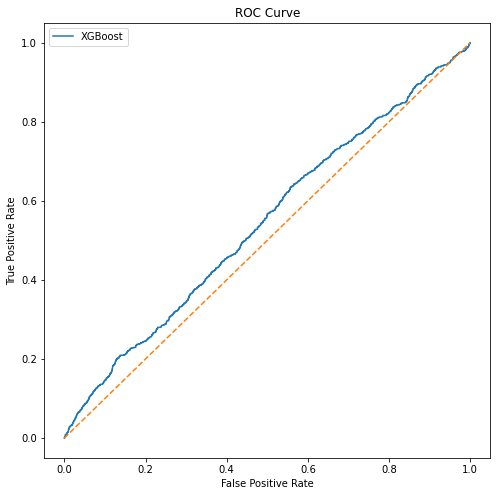

In [82]:
evaluation_df = evaluate_model(xgb_clf, X_test_all, y_test, 'XGBoost')

### Plot feature importances - 

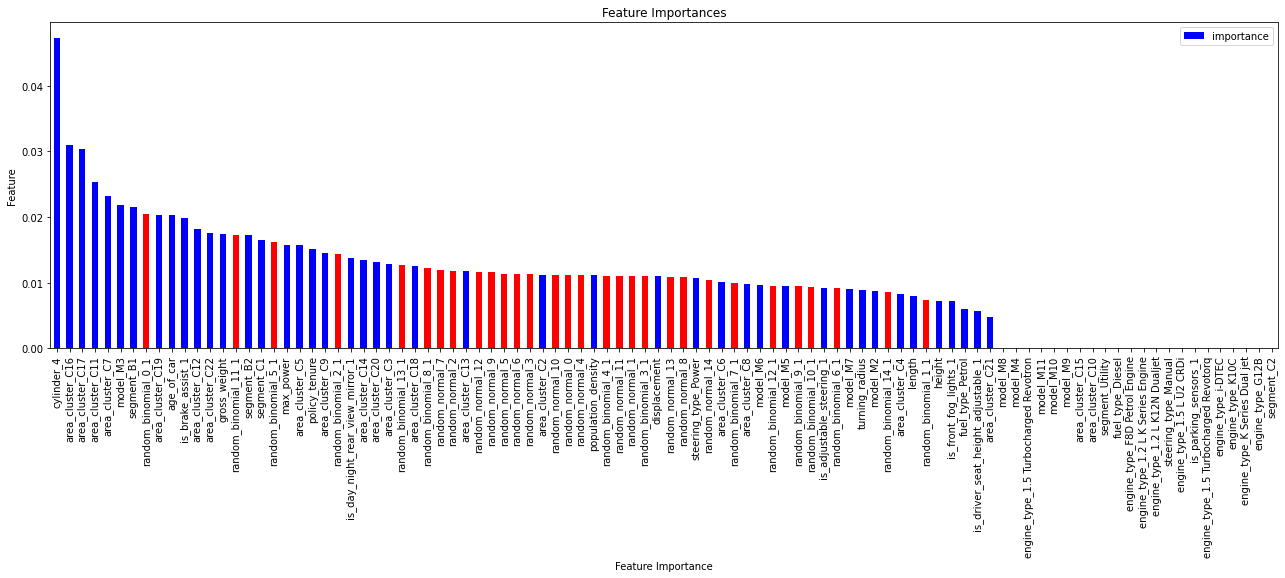

In [83]:
##get fesatures importances
feature_importances = xgb_clf.feature_importances_
##create a dataframe with the feature importances
feature_importances_df = pd.DataFrame({'feature': X_train_all.columns, 'importance': feature_importances})
##sort the values in descending order
feature_importances_df.sort_values(by='importance', ascending=False, inplace=True)
##determine if feature is random
feature_importances_df['is_random'] = feature_importances_df['feature'].str.contains('random')
##plot the feature importances, with random features in red
feature_importances_df.plot(kind='bar', x='feature', y='importance', color=feature_importances_df['is_random'].map({True: 'red', False: 'blue'}), figsize=(22, 6))
plt.title('Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [84]:
##get the third highest random feature importance
cutoff = feature_importances_df[feature_importances_df['is_random'] == True]['importance'].iloc[2]
##get the features with importance greater than the second highest random feature importance
features_to_keep = feature_importances_df[feature_importances_df['importance'] > cutoff]['feature'].tolist()
##remove the random features
features_to_keep = [col for col in features_to_keep if not col.startswith('random')]
##print message saying how many features left
print(f'{len(features_to_keep)} features left')

15 features left


### Re-train with only features that outperformed at least 3 random variables

Ratio of 0s to 1s in the train set: 14.63


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoost with feature selection Results
Precision: 0.066
Recall: 0.920
F1: 0.122
ROC AUC: 0.596

Confusion Matrix
[[1135 9834]
 [  60  690]]


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


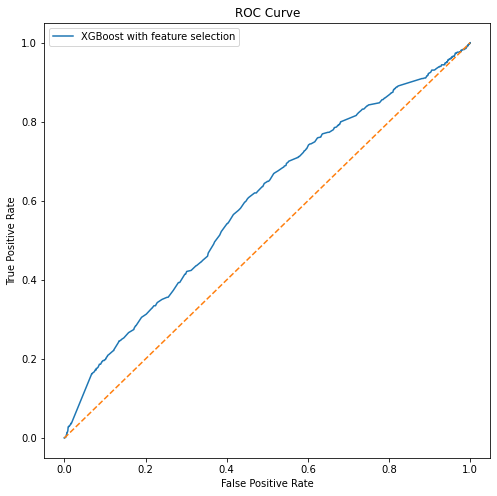

C:\Users\harry\AppData\Local\Temp/ipykernel_24684/1493576382.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append(evaluate_model(xgb_clf2, X_test, y_test, 'XGBoost with feature selection'))


In [85]:
##re-create X and y variables
X = data2[features_to_keep]
y = data2['is_claim']

##subset X_train and X_test to only include the features to keep (not repeating test-train split)
X_train = X_train_all[features_to_keep]
X_test = X_test_all[features_to_keep]

##calculate ratio of 1s to 0s in the train set
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Ratio of 0s to 1s in the train set: {ratio:.2f}")

##create classifier object
xgb_clf2 = xgb.XGBClassifier(n_estimators=500, 
                            scale_pos_weight=ratio*3, 
                            random_state=42, 
                            n_jobs=-1,
                            objective='binary:logistic', 
                            eval_metric='logloss')

##fit the model to the training data
xgb_clf2.fit(X_train, y_train)

##make predictions on the test set, append df to evaluation_df
evaluation_df = evaluation_df.append(evaluate_model(xgb_clf2, X_test, y_test, 'XGBoost with feature selection'))

##  6) Data Resampling 

Repeat model training again, this time using `imblearn.over_sampling.SMOTENC` to synthesise "fake data" to balance the features

Ratio of 0s to 1s in the train set: 1.00


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoost with SMOTE Results
Precision: 0.081
Recall: 0.576
F1: 0.143
ROC AUC: 0.584

Confusion Matrix
[[6088 4881]
 [ 318  432]]


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


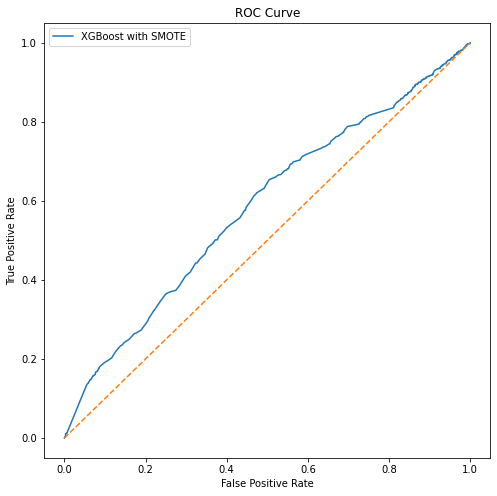

C:\Users\harry\AppData\Local\Temp/ipykernel_24684/2529734395.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append(evaluate_model(xgb_clf3, X_test, y_test, 'XGBoost with SMOTE'))


In [86]:
##which columns are categorical (i.e not in num_cols)
cat_cols = [col for col in X_train.columns if col not in num_cols]
##get numerical positions of categorical columns
cat_pos = [X_train.columns.get_loc(col) for col in cat_cols]

###use resample to balance the classes with imblearn
sme = SMOTENC(random_state=42, categorical_features=cat_pos)
X_res, y_res = sme.fit_resample(X_train, y_train.astype(int))

#calculate ratio of 1s to 0s in the train set
re_sampled_ratio = y_res.value_counts()[0] / y_res.value_counts()[1]
print(f"Ratio of 0s to 1s in the train set: {re_sampled_ratio:.2f}")

##create classifier object
xgb_clf3 = xgb.XGBClassifier(n_estimators=500,
                            scale_pos_weight=1,
                            learning_rate=0.2,
                            max_depth=6,
                            min_child_weight= 1,
                            random_state=42,
                            n_jobs=-1,
                            objective='binary:logistic',
                            eval_metric='logloss')

##fit the model to the training data
xgb_clf3.fit(X_res, y_res)

##evaluate model performance, append df to evaluation_df
evaluation_df = evaluation_df.append(evaluate_model(xgb_clf3, X_test, y_test, 'XGBoost with SMOTE'))

## 7) Hyperparamater tuning with `GridSearchCV`

Fitting 12 folds for each of 648 candidates, totalling 7776 fits


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'gamma': 0.25, 'learning_rate': 0.15, 'max_depth': 5, 'min_child_weight': 2, 'scale_pos_weight': 14, 'subsample': 1}
Best cross-val score: 0.141
XGBoost with GridSearch Results
Precision: 0.082
Recall: 0.620
F1: 0.144
ROC AUC: 0.599

Confusion Matrix
[[5737 5232]
 [ 285  465]]


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


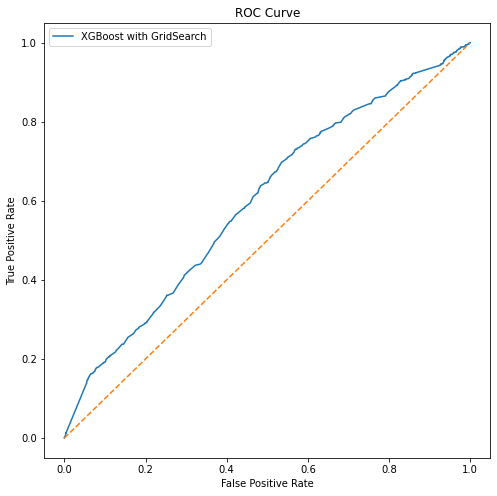

C:\Users\harry\AppData\Local\Temp/ipykernel_24684/4181580675.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append(evaluate_model(best_xgb_clf, X_test, y_test, 'XGBoost with GridSearch'))


In [87]:
##use gridearch to find the best parameters - focus on roc-auc
from sklearn.model_selection import GridSearchCV

##create classifier object
xgb_clf4 = xgb.XGBClassifier(n_estimators=300,
                            random_state=42,
                            n_jobs=-1,
                            objective='binary:logistic',
                            eval_metric='logloss')

##create parameter grid 
param_grid = {
    'max_depth': [5,6,10],
    'gamma': [0,0.1, 0.25],
    'learning_rate': [0.15,0.2,0.25],
    'subsample': [0.85, 1],
    'min_child_weight': [1,2,4],
    'scale_pos_weight': [5,10,14,20],
}

##create grid search object, scored by F1 score
grid_search = GridSearchCV(xgb_clf4, param_grid, scoring='f1', cv=12, n_jobs=-1, verbose=1)

##fit the grid search object to the training data
grid_search.fit(X_train, y_train)

##get the best parameters
print(grid_search.best_params_)

##print best score
print(f"Best cross-val score: {grid_search.best_score_:.3f}")


## get best estimator
best_xgb_clf = grid_search.best_estimator_

##evaluate model performance, append df to evaluation_df
evaluation_df = evaluation_df.append(evaluate_model(best_xgb_clf, X_test, y_test, 'XGBoost with GridSearch'))

                            

## 8) Final Model Evaluation

In [139]:
##which model had the best performance?
evaluation_df.sort_values('f1', ascending=False)


,precision,recall,f1,roc_auc
XGBoost with GridSearch,0.081622,0.620000,0.144253,0.598838
XGBoost with SMOTE,0.081310,0.576000,0.142504,0.583885
XGBoost with feature selection,0.065564,0.920000,0.122406,0.595912
XGBoost,0.102729,0.085333,0.093227,0.543196


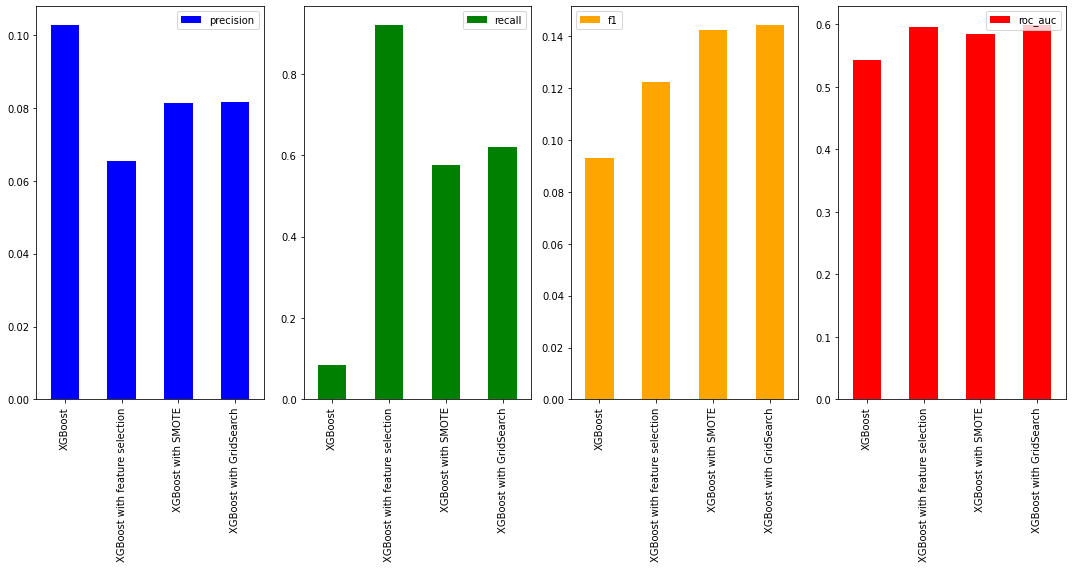

In [140]:
##plot the evaluation_df - side by side plots of precision, recall, f1, and roc-auc by model
##create 5x1 subplots with x-axis = index
fig, axes = plt.subplots(1,4, figsize=(15,8))
evaluation_df.plot(kind='bar', y='precision', ax=axes[0], color='blue')
evaluation_df.plot(kind='bar',  y='recall', ax=axes[1], color='green')
evaluation_df.plot(kind='bar',  y='f1', ax=axes[2], color='orange')
evaluation_df.plot(kind='bar',  y='roc_auc', ax=axes[3], color='red')
plt.tight_layout()
plt.show()


## Plot the xgboost prediction probability against probability of having a claim

We can see much higher relavance of xgboost predictions to the target varaible than with `Policy Tenure` (varaible with highest lasso/ridge coefficents). 

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


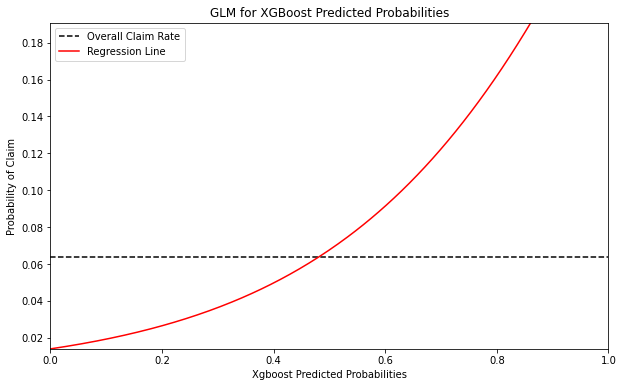

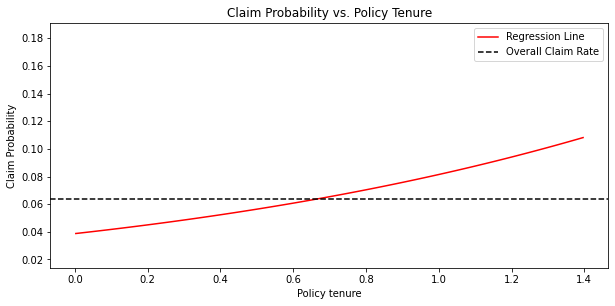

In [136]:

##get precition proba from xgb4
y_pred_proba = best_xgb_clf.predict_proba(X_test)[:,1]
##make binary GLM for pred_proba vs y_test
##glm = sm.GLM(y_test, y_pred_proba, family=sm.families.Binomial()).fit()



##fit a binomial regression model
binomial_reg = sm.GLM(y_test, sm.add_constant(y_pred_proba), family=sm.families.Binomial()).fit()

# Generate predicted values for plotting the line
x_pred = np.linspace( y_pred_proba.min(), y_pred_proba.max(), 250)
##make GLM predictions
GLM_y_pred = binomial_reg.predict(sm.add_constant(x_pred))

# Plot in subplot side by side with policy_tenure plot


fig, ax = plt.subplots(figsize=(10, 6))
##add horizontal line at target_counts[1]
ax.axhline(target_counts[1], color='k', linestyle='--', label='Overall Claim Rate')
ax.plot(x_pred, GLM_y_pred, color='r', label='Regression Line')

##set x axis to go from 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(GLM_y_pred.min(), GLM_y_pred.max())
# Add plot labels and legend
ax.set_title('GLM for XGBoost Predicted Probabilities')
ax.set_xlabel('Xgboost Predicted Probabilities')
ax.set_ylabel('Probability of Claim')
ax.legend()
plt.show()

plot_binomial_regression(data['policy_tenure'], title='Claim Probability vs. Policy Tenure',xlabel='Policy tenure',
                         ylabel='Claim Probability', ylim=(GLM_y_pred.min(), GLM_y_pred.max()))

